# Resolución de problema de 4 viajantes recorriendo la mínima distancia posible con algoritmo genético

In [1]:
import matplotlib.pyplot as plt
import networkx
import numpy as np 
import operator
import pandas as pd
import random 
from math import sqrt
%matplotlib inline

In [2]:
def get_index_positions(list_of_elems, element):
    ''' 
    Devuelve todos los índices de apariciones de un elemento en la lista list_of_elems
    '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Busca el elemento en la lista desde index_pos hasta el final de la lista
            index_pos = list_of_elems.index(element, index_pos)
            # Añade el índice en la lista
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

In [3]:
def minDistance(A, B, E):
    '''
    Devuelve la mínima distancia entre una línea AB y un punto E
    '''
    # vector AB
    AB = [None, None]
    AB[0] = B[0] - A[0]
    AB[1] = B[1] - A[1]

    # vector BP
    BE = [None, None]
    BE[0] = E[0] - B[0]
    BE[1] = E[1] - B[1]

    # vector AP
    AE = [None, None];
    AE[0] = E[0] - A[0]
    AE[1] = E[1] - A[1]

    # Variables to store dot product

    # Calculating the dot product
    AB_BE = AB[0] * BE[0] + AB[1] * BE[1]
    AB_AE = AB[0] * AE[0] + AB[1] * AE[1]

    # Minimum distance from
    # point E to the line segment
    reqAns = 0;

    # Case 1
    if (AB_BE > 0):
        # Finding the magnitude
        y = E[1] - B[1]
        x = E[0] - B[0]
        reqAns = sqrt(x * x + y * y)

    # Case 2
    elif (AB_AE < 0) :
        y = E[1] - A[1];
        x = E[0] - A[0];
        reqAns = sqrt(x * x + y * y)

    # Case 3
    else:
        # Finding the perpendicular distance
        x1 = AB[0];
        y1 = AB[1];
        x2 = AE[0];
        y2 = AE[1];
        mod = sqrt(x1 * x1 + y1 * y1);
        reqAns = abs(x1 * y2 - y1 * x2) / mod

    return reqAns

In [4]:
class node:
    '''
    creación de nodos: cada nodo es un cliente con sus respectivas coordenadas.
    '''
    def __init__(self, lon, lat):
        self.lon = lon
        self.lat = lat
    
    def distance(self, city):
        delta_lon = abs(self.lon - city.lon)
        delta_lat = abs(self.lat - city.lat)
        # La relación (1/0.008) es para aproximar (cálculo no exacto) la relación entre grados y km
        distance = (1/0.008) * np.sqrt((delta_lon ** 2) + (delta_lat ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.lon) + "," + str(self.lat) + ")"

In [5]:
def farthest_clients_selection(df):
    '''
    El objetivo es conocer a los 4 clientes más separados entre sí y entre la sede de transporte.
    La elección es de 4 porque se utilizan 4 camiones y por tanto se crean 4 rutas de reparto.
    La estrategia es que cada camión vaya a uno de los clientes más separados entre sí y entre la sede de transporte.
    Para cumplir la estrategia se seguirá el siguiente orden:
    1º se encuentra al cliente más lejano de la sede de transportes --> cliente1
    2º se encuentra al cliente más lejano de la sede de transportes y del cliente1 --> cliente2
    3º se encuentra al cliente más lejano de la sede de transportes, del cliente1 y del cliente2 --> cliente3
    4º se encuentra al cliente más lejano de la sede de transportes, del cliente1, del cliente2 y del cliente3 --> cliente4
    '''
    # nodos de ciudades y sus coordeenadas
    node_list = [] 

    # clientes (que no repiten coordenadas) que están a mayor distancia entre sí y entre la sede
    unique_point_clients = []

    # clientes más separados entre sí y entre la sede de transporte
    max_dist_clients = []

    for route in range(4):
        # lista de distancias de cada cliente a la sede y a los clientes más lejanos
        max_dist = []

        # para cada cliente
        for index, row in df.iterrows():
            # lista de distancias del cliente a la sede y a los clientes más lejanos
            acc_dist = []
            # si el cliente no es uno de los clientes más lejanos entre todos los clientes y la sede de transporte
            if index not in max_dist_clients:
                # se accede a las coordenadas del cliente
                client_node = node(lon = row['lon'], lat = row['lat'])
                if route == 0:
                    # sólo en el primer recorrido almaceno los nodos de ciudades y sus coordenadas.
                    node_list.append(client_node)
                    # En el primer recorrido se busca al cliente más lejano de la sede de transportes,
                    # por ello se calculan las distancias de cada cliente a la sede.
                    dist = client_node.distance(headq)
                    max_dist.append([dist])
                else:
                    # En los siguientes recorridos,
                    # para cada cliente seleccionado como cliente lejano con sólo una posible ruta:
                    for faraway_client in unique_point_clients:
                        # cálculo de las distancias de cada cliente respecto a los clientes más lejanos
                        dist = client_node.distance(node_list[faraway_client])
                        acc_dist.append(dist)
                    max_dist.append(acc_dist)
            else:
                # si el cliente forma parte de los clientes más lejanos añadimos una distancia
                # infinita para que no vuelva a tener en cuenta como nuevo cliente más lejano de los demás clientes y la sede.
                for faraway_client in unique_point_clients:
                    acc_dist.append(99999999999999)
                max_dist.append(acc_dist)

        min_distances = 0
        def_faraway_clients = []
        # Para cada cliente y sus distancias (respecto a los clientes más lejanos y la sede)
        # se elige al siguiente cliente más lejano siempre y cuando tenga la mayor distancia con el resto
        # de clientes más lejanos y la sede en conjunto.
        for client, distances in enumerate(max_dist):
            if 99999999999999 not in distances:
                if min(distances) > min_distances:
                    min_distances = min(distances)
                    def_faraway_clients = [client]
                elif min(distances) == min_distances:
                    def_faraway_clients.append(client)

        # A los clientes más lejanos se le añade el nuevo clientee
        unique_point_clients.append(def_faraway_clients[-1])
        # Si hubiese más de un cliente con las mismas coordenadas se añade a la lista max_dist_clients
        for def_faraway_client in def_faraway_clients:
            max_dist_clients.append(def_faraway_client)

    # Devuelvo los clientes más lejanos entre sí y la sede y, la lista de nodos de coordenadas
    return unique_point_clients, node_list

In [6]:
def clustering(df, unique_point_clients, node_list, headq):
    '''
    Si el cliente No está entre los clientes que están a mayor distancia entre sí y entre la sede,
    calculamos la mínima distancia entre dicho cliente y los clientes más lejanos y le asigno su cliente
    más lejano con la menor distancia entre sí.
    
    Los clientes más lejanos (unique_point_clients) se utilizan como los nombres de rutas.
    '''
    parent_clients = [] # lista con la asignación de cada cliente a su cluster

    for client in range(len(df)-1):
        if client not in unique_point_clients:
            min_distance = 99999999999999
            parent_client = None
            for point_client in unique_point_clients:
                distance = minDistance([node_list[point_client].lon,node_list[point_client].lat],[headq.lon, headq.lat], [node_list[client].lon,node_list[client].lat])
                if distance < min_distance:
                    min_distance = distance
                    parent_client = point_client
        else:
            parent_client = client
        parent_clients.append(parent_client)
    parent_clients.append(9999)
    return parent_clients

In [7]:
# carga de dataset
df = pd.read_csv("coord.csv", sep=";")
# añadido de coordenadas de la sede de transportes al dataset
df2 = {'id_cliente':0, 'lon':-3.69453, 'lat':40.54557}
df = df.append(df2,ignore_index=True)

# nodo de la sede de transportes
headq = node(lon = -3.69453, lat = 40.54557)

In [8]:
def data_prep_1(df):
    '''
    Devuelve una nueva variable, routes, que se encarga de asignar a cada cliente una de cuatro rutas posibles.
    '''
    # nodo de la sede de transportes
    headq = node(lon = -3.69453, lat = 40.54557)

    # asignación de clientes más lejanos entre sí y la sede
    unique_point_clients = farthest_clients_selection(df)[0]
    node_list = farthest_clients_selection(df)[1]

    # asignación de rutas por cliente
    return clustering(df, unique_point_clients, node_list, headq)

In [9]:
def route_assignment_2(x):
    if x['new_lon'] == 0 and x['new_lat'] == 0:
        return 9999
    if x['new_lon'] > 0:
        if x['new_lat'] > 0:
            return 1
        else:
            return 2
    else:
        if x['new_lat'] > 0:
            return 3
        else:
            return 4

In [10]:
def data_prep_2(df):
    '''
    Devuelve una nueva variable, routes, que se encarga de asignar a cada cliente una de cuatro rutas posibles.
    '''
    df['new_lon'] = df['lon'].apply(lambda x: x - (-3.69453))
    df['new_lat'] = df['lat'].apply(lambda x: x - 40.54557)
    
    return df.apply(lambda x: route_assignment_2(x), axis = 1)

In [11]:
def apply_color(df):
    '''
    devuelve un diccionario con un color para cada ruta
    '''
    color1 = df.routes.unique()[0]
    color2 = df.routes.unique()[1]
    color3 = df.routes.unique()[2]
    color4 = df.routes.unique()[3]
    colors = {color1: 'red', color2: 'blue', color3: 'pink', color4: 'green', 9999: 'grey'}
    return colors

### Mapa de la opción 1 de reparto de cuatro rutas entre los clientes.

El propósito de esta opción es:
- encontrar los cuatro clientes más lejanos entre sí y la sede de transportes y adjuntar a cada uno una ruta diferente.
- para cada cliente encontrar sus distancias con las líneas formada por la sede y cada uno de los cuatro clientes más lejanos entre sí y la sede. 
    - Elegir la mínima distancia y asociar el correspondiente cliente más lejano.
    - Asignar a cada cliente la ruta a la que pertenece su cliente más lejano asociado anteriormente.

<AxesSubplot:xlabel='lon', ylabel='lat'>

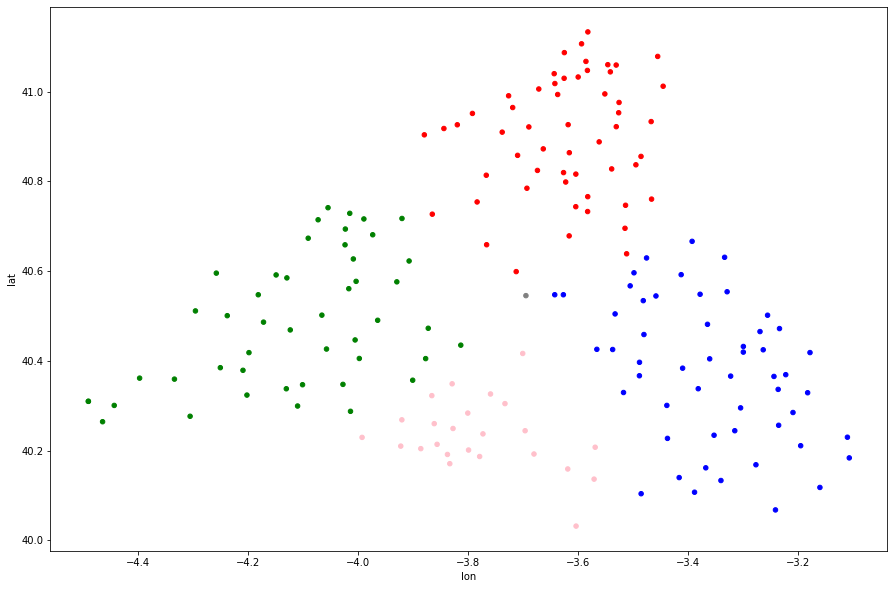

In [12]:
# Plot para una asignación de rutas según f(data_prep_1)
df1 = df.copy()
df1['routes'] = data_prep_1(df)
df1.plot(kind='scatter',x='lon',y='lat',
        figsize=(15,10),
        c=df1['routes'].map(apply_color(df1)))

### Mapa de la opción 2 de reparto de cuatro rutas entre los clientes.

El propósito de esta opción es dividir el espacio entre 4 (una por ruta) y asignar a cada cuadrante los clientes a los que pertenzca dado que la sede está en el centro.

<AxesSubplot:xlabel='lon', ylabel='lat'>

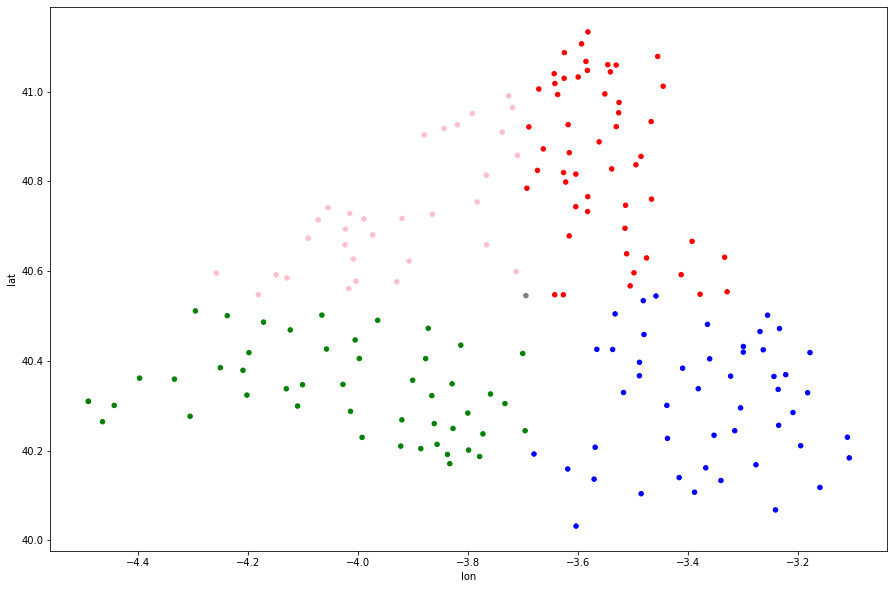

In [13]:
# Plot para una asignación de rutas según f(data_prep_2)
df2 = df.copy()
df2['routes'] = data_prep_2(df)
df2.plot(kind='scatter',x='lon',y='lat',
        figsize=(15,10),
        c=df2['routes'].map(apply_color(df2)))

In [14]:
def initial_route(node_list):
    '''
    Obtener una ruta inicial de modo que:
    - la mitad de los clientes que están a menos del primer cuartil de distancia a la sede se añaden aleatoriamente al principio de la ruta.
    - la mitad de los clientes entre el primer cuartil y segundo cuartil de distancia a la sede se añaden aleatoriamente a la ruta.
    - la mitad de los clientes entre el segundo y tercer cuartil de distancia a la sede se añaden aleatoriamente a la ruta.
    - los clientes más allá del tercer cuartil de distancias a la sede se añaden aleatoriamente a la ruta.

    Desde el final de la ruta se van añadiendo el resto de mitades restantes en el orden correspodiente.
    Ejemplo: [0,1,2,3,4,5,6] --> Resultado: [0,2,4,6,5,3,1]
    '''
    headq_dist = {}
    initial_route = []

    node_list = node_list[:-1] # se elimina el nodo de la sede de transportes
    for i in range(len(node_list)):
        # cálculo de la distancia de cada cliente a la sede y añadido de la distancia (key) y el cliente (value) al diccionario headq_dist
        dist = node_list[i].distance(headq)
        headq_dist.setdefault(dist, [])
        headq_dist[dist].append(i)
    
    # cálculo de los cuartiles de todas las distancias
    q1 = np.percentile(list(headq_dist.keys()), 25)
    q2 = np.percentile(list(headq_dist.keys()), 50)
    q3 = np.percentile(list(headq_dist.keys()), 75)

    # filtro de distancias en diferentes listas según el cuartil al que pertenecen
    q1_dist = list(filter(lambda x: x <= q1, headq_dist.keys()))
    q2_dist = list(filter(lambda x: q1 < x <= q2, headq_dist.keys()))
    q3_dist = list(filter(lambda x: q2 < x <= q3, headq_dist.keys()))
    q4_dist = list(filter(lambda x: x > q3, headq_dist.keys()))

    # conversión de las distancias en sus correspondientes clientes en diferentes listas según el cuartil de distancia al que pertenecen
    q1_nodes = []
    q2_nodes = []
    q3_nodes = []
    q4_nodes = []

    [q1_nodes.append(index) for dist in q1_dist for index in headq_dist[dist]] 
    [q2_nodes.append(index) for dist in q2_dist for index in headq_dist[dist]] 
    [q3_nodes.append(index) for dist in q3_dist for index in headq_dist[dist]] 
    [q4_nodes.append(index) for dist in q4_dist for index in headq_dist[dist]] 

    # para cada cuartil de clientes se añade la mitad de ellos al principio o final de la ruta
    for q in [q4_nodes,q3_nodes,q2_nodes,q1_nodes]:
        random.shuffle(q)

        [initial_route.append(node_list[i]) for i in q[: len(q)//2]]
        [initial_route.insert(0,node_list[i]) for i in q[len(q)//2:]]

    initial_route.insert(0,headq)
    initial_route.append(headq)

    return initial_route

In [15]:
class fitness:
    '''
    definición de clas que dice lo buena o mala que es la solución.
    partiendo de la secuencia de ciudades calcula la longitud.
    '''
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def route_distance(self):
        if self.distance ==0:
            segment_distance = 0
            for i in range(0, len(self.route)):
                from_node = self.route[i]
                to_node = None
                if i + 1 < len(self.route)-1:
                    to_node = self.route[i + 1]
                else:
                    to_node= self.route[0]
                segment_distance += from_node.distance(to_node)
            self.distance = segment_distance
        return self.distance
            
    
# Ordenación de las rutas
def sorting_routes(population):
    dict_fitness = {}
    for i in range(0,len(population)):
        dict_fitness[i] = fitness(population[i]).route_distance()
    return sorted(dict_fitness.items(), key = operator.itemgetter(1))

In [16]:
def selection(sorted_population, top_n, worse_solutions):
    '''
    función que dada una población se queda con los top_n mejores y los worse_solutions peores
    '''
    solutions_selected = []
    
    for idx, ele in enumerate(sorted_population):
        solutions_selected.append(ele)
        if idx + 1 ==  int(top_n*len(sorted_population)):
            break
    
    new_list = list(set(sorted_population) - set(solutions_selected))
    
    worse_solutions = int(worse_solutions*len(sorted_population))
    if worse_solutions  > len(new_list):
        worse_solutions = len(new_list)
    new_selection = random.sample(new_list, worse_solutions)
 
    return solutions_selected + new_selection

In [17]:
def crossover(chrom_1, chrom_2):
    '''
    dados dos elementos de una población genero un tercer individuo diferente basado en la combinación de ambos.
    '''
    chrom_1 = [ele for ele in chrom_1 if ele.lon != headq.lon and ele.lat != headq.lat]
    chrom_2 = [ele for ele in chrom_2 if ele.lon != headq.lon and ele.lat != headq.lat]
    child_1 = [] #ruta
    child_2 = [] #ruta
    
    # Determino al azar dos genes (en nuestro caso, ciudades dentro de la ruta)
    gene_1 = int(random.random() * len(chrom_1))
    gene_2 = int(random.random() * len(chrom_1))
    
    start = min(gene_1, gene_2)
    end = max(gene_1, gene_2)

    # Tomo del cromosoma 1 las ciudades comprendidas entre esos dos genes
    for i in range(start, end):
        child_1.append(chrom_1[i])
    
    # Completo la ruta con las ciudades que no están en la lista anterior
    # siguiendo el orden en el que están en el cromosoma 2
    child_2 = [item for item in chrom_2 if item not in child_1]

    child = [headq]+child_1 + child_2+[headq]
    return child

In [18]:
def mutate(chrom):
    '''cambia de orden 2 ciudades en la ruta y se obtiene una ruta diferente'''
    chrom_mutated = chrom[:]
    chrom_mutated = [ele for ele in chrom_mutated if ele.lon != headq.lon and ele.lat != headq.lat]
    
    idx = range(len(chrom_mutated))
    i1, i2 = random.sample(idx, 2) # Sin reemplazaminto
    chrom_mutated[i1], chrom_mutated[i2] = chrom_mutated[i2], chrom_mutated[i1]
    
    return [headq]+chrom_mutated+[headq]

In [19]:
def create_next_generation(population, sorted_population, 
                           top_n, worse_solutions, rate_crossovers):
    '''
    combina la selección, la mutación y los crossovers hasta generar una nueva población.
    '''
    population_size = len(population)

    new_generation = []
    # Parto de la generación actual:

    # 1.- Selecciono los que van a sobrevivir:
    parents = selection(sorted_population, top_n, worse_solutions)

    for ele in parents:
        new_generation.append(population[ele[0]])

    # 2.- Hago los crossovers correspondientes en la proporción indicada en 
    #     rate_crossovers
    number_crossovers = int(rate_crossovers * (population_size*(1 - (top_n + worse_solutions))))

    crossovers = []
    for i in range(0, number_crossovers):
        idx1, idx2 = np.random.choice(np.arange(len(new_generation)), size=2, replace=False)
        new_chrom = crossover(new_generation[idx1], new_generation[idx2])
        new_generation.append(new_chrom)

    number_mutations = int(population_size - number_crossovers - len(parents))

    # 3.- Muto los cromosomas según el número indicado
    mutations = []
    for i in range(0, number_mutations):
        idx1 =  np.random.choice(np.arange(len(new_generation)), size=1, replace=False)[0]
        new_chrom = mutate(new_generation[idx1])
        new_generation.append(new_chrom)

    return new_generation

In [20]:
def genetic_tsp(population,  top_n, worse_solutions, rate_crossovers, num_generations, population_size,node_list):
    '''
    partiendo de una población inicial, a lo largo de una serie de iteraciones/generaciones, 
    los cromosomas van sobreviviendo y desapareciendo, mutando y combinándose hasta llegar a una solución 
    mucho mejor que la inicial.
    '''
    population = []
    
    # Generamos una población inicial
    for i in range(0, population_size):
        population.append(initial_route(node_list))
    
    # Ordenamos la población atendiendo a la longitud de la ruta.
    sorted_population = sorting_routes(population)

    # Menor distancia:
    print("Mejor distancia: " + str(sorted_population[0][1]) + " km.")
    
    # Creamos listas vacías para almacenar la menor distancia y mejor solución
    outcomes = []
    best_routes = []
    outcomes.append(int(sorted_population[0][1]))
    best_routes.append(population[sorted_population[0][0]])
    
    
    
    for i in range(0, num_generations):
        
        # Partiendeo de una generación llamamos a la función que se encarga de seleccionar, mutar y 
        # ejecutar los cruces para la población
        population = create_next_generation(population, 
                                            sorted_population, 
                                            top_n, 
                                            worse_solutions, 
                                            rate_crossovers)
        
        sorted_population = sorting_routes(population)
        
        if i%100 == 0:
            print("Generación " + str(i+1) + "    " + "Mejor distancia: " + str(sorted_population[0][1]) + " km.")
        
        outcomes.append(int(sorted_population[0][1]))
        best_routes.append(population[sorted_population[0][0]])
        
    print("Generación " + str(i+1) + "    " + "Mejor distancia: " + str(sorted_population[0][1]) + " km.")
    
    return outcomes, best_routes, population

In [21]:
def results(df):
    '''
    dado una asignación de ruta a cliente,
    se obtiene cada ruta de clientes óptima y la mínima distancia recorrida por cada ruta.
    '''
    unique_point_clients = df['routes'].unique()
    node_list = farthest_clients_selection(df)[1]

    for point in unique_point_clients[:4]:
        print("Nombre ruta: ",point)
        cities = list(df[df['routes'] == point].index)
        route = [node_list[i] for i in cities]
        evolution, best_routes, new_population = genetic_tsp(population, 
                                                         top_n, 
                                                         worse_solutions, 
                                                         rate_crossovers, 
                                                         num_generations, 
                                                         population_size,
                                                         route)
    return evolution, best_routes, new_population

In [22]:
population_size = 800
num_generations = 300
population = []

# Dada la población de una generación:
# Porcentaje de los mejores cromosomas que sobrevivirán
top_n = 0.05
# Porcentaje de los peores que, al azar, sobrevivirán
worse_solutions = 0.01
# Una vez seleccionado éstos, hasta completar el total de población de cada
# generación, decidiremos cómo se reparten entre crossovers y mutaciones
rate_crossovers = 0.7
# Por tanto: rate_mutations = 1-rate_crossovers 

### Resultados para las opciones de reparto de rutas

In [23]:
results(df2)

Nombre ruta:  1
Mejor distancia: 782.8207464964197 km.
Generación 1    Mejor distancia: 781.3009041463647 km.
Generación 101    Mejor distancia: 463.0015833397162 km.
Generación 201    Mejor distancia: 407.68410145216137 km.
Generación 300    Mejor distancia: 391.20599110287196 km.
Nombre ruta:  2
Mejor distancia: 928.9388172933973 km.
Generación 1    Mejor distancia: 928.9388172933973 km.
Generación 101    Mejor distancia: 531.2118769676559 km.
Generación 201    Mejor distancia: 496.167193021213 km.
Generación 300    Mejor distancia: 476.0582372936562 km.
Nombre ruta:  3
Mejor distancia: 626.364229534507 km.
Generación 1    Mejor distancia: 567.7496291232194 km.
Generación 101    Mejor distancia: 282.9672323703512 km.
Generación 201    Mejor distancia: 276.2643993627715 km.
Generación 300    Mejor distancia: 276.2643993627715 km.
Nombre ruta:  4
Mejor distancia: 859.920911438491 km.
Generación 1    Mejor distancia: 856.6137436662609 km.
Generación 101    Mejor distancia: 527.553376147

([859,
  856,
  850,
  818,
  816,
  749,
  749,
  749,
  749,
  749,
  749,
  749,
  741,
  725,
  713,
  711,
  703,
  703,
  703,
  703,
  703,
  698,
  698,
  690,
  682,
  682,
  656,
  644,
  612,
  610,
  610,
  610,
  610,
  610,
  578,
  578,
  578,
  578,
  571,
  571,
  571,
  571,
  571,
  571,
  571,
  571,
  571,
  571,
  571,
  570,
  570,
  566,
  566,
  559,
  559,
  559,
  559,
  558,
  558,
  554,
  553,
  553,
  553,
  553,
  549,
  549,
  549,
  549,
  549,
  541,
  541,
  538,
  538,
  538,
  537,
  537,
  537,
  537,
  537,
  537,
  537,
  537,
  537,
  537,
  537,
  537,
  535,
  535,
  530,
  530,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  527,
  525,
  525,
  515,
  511,
  511,
  511,
  511,
  511,
  511,
  511,
  511,
  511,
  511,
  511,
  504,
  504,
  504,
  504,
  504,
  504,
  504,
  504,
  504,
  504,
  504,

In [26]:
391.20599110287196+476.0582372936562+276.2643993627715+481.0308469900606

1624.55947474936

Con la opción 2 de reparto de rutas los cuatro vehículos recorren un total de 1624.56 km.

In [24]:
results(df1)

Nombre ruta:  137
Mejor distancia: 806.3073411464852 km.
Generación 1    Mejor distancia: 788.1182387972086 km.
Generación 101    Mejor distancia: 496.99360018787655 km.
Generación 201    Mejor distancia: 473.25744748695706 km.
Generación 300    Mejor distancia: 451.4076066353354 km.
Nombre ruta:  54
Mejor distancia: 960.6235458148058 km.
Generación 1    Mejor distancia: 924.8228270307762 km.
Generación 101    Mejor distancia: 565.1658172628701 km.
Generación 201    Mejor distancia: 487.6670904861081 km.
Generación 300    Mejor distancia: 482.6645629487161 km.
Nombre ruta:  143
Mejor distancia: 341.93147435193436 km.
Generación 1    Mejor distancia: 341.93147435193436 km.
Generación 101    Mejor distancia: 240.4562890944965 km.
Generación 201    Mejor distancia: 238.31648124965983 km.
Generación 300    Mejor distancia: 234.2728793009436 km.
Nombre ruta:  124
Mejor distancia: 934.8303506490442 km.
Generación 1    Mejor distancia: 889.8216805572827 km.
Generación 101    Mejor distancia: 

([934,
  889,
  854,
  814,
  814,
  783,
  757,
  736,
  736,
  732,
  725,
  725,
  725,
  725,
  718,
  716,
  713,
  713,
  706,
  693,
  686,
  685,
  685,
  685,
  667,
  667,
  667,
  657,
  634,
  634,
  625,
  625,
  625,
  625,
  625,
  615,
  615,
  607,
  582,
  582,
  582,
  578,
  573,
  573,
  548,
  548,
  548,
  548,
  548,
  548,
  548,
  528,
  528,
  528,
  528,
  528,
  528,
  528,
  528,
  528,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  523,
  517,
  517,
  517,
  517,
  517,
  517,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  513,
  501,
  501,
  501,
  501,
  501,
  501,
  500,
  500,
  500,
  500,
  500,
  500,
  496,
  496,
  496,
  496,
  496,
  496,
  496,
  496,
  494,
  494,
  494,
  494,
  492,
  492,
  492,
  492,
  482,
  481,
  481,
  481,
  481,
  481,
  481,
  480,
  480,
  480,
  480,
  480,
  480,
  467,
  467,
  467,
  467,
  467,

In [25]:
451.4076066353354+482.6645629487161+234.2728793009436+442.85568960926423

1611.2007384942594

Con la opción 1 de reparto de rutas los cuatro vehículos recorren un total de 1611.2 km.

Se ha conseguido alcanzar un mínimo de 1611.2 km para completar todos los repartos a los clientes con cuatro vehículos.

La opción 1 de reparto de rutas parece ser un poco más óptima que la opción 2.

**Duda**: mi propósito era mejorar la opción 2 de elección de rutas pero, tras ver los resultados finales, no hay apenas diferencia. No entiendo por qué no hay más diferencia si desde mi razonamiento esta opción debería ser más óptima. No sé si el problema es mi razonamiento o mi pseudocódigo.